# Predict Sale Price

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/pa_heritage_housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/pa_heritage_housing'

Create new folder for plots and pipelines

In [35]:
import os
try:
  os.makedirs(name='outputs/plots') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

try:
  os.makedirs(name='outputs/pipelines')
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/plots'
[Errno 17] File exists: 'outputs/pipelines'


# Load Data

In [5]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_price_records.csv"))

print(df)
df.head(3)

      Unnamed: 0  1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1  \
0              0       856     854.0           3.0           No         706   
1              1      1262       0.0           3.0           Gd         978   
2              2       920     866.0           3.0           Mn         486   
3              3       961       0.0           0.0           No         216   
4              4      1145       0.0           4.0           Av         655   
...          ...       ...       ...           ...          ...         ...   
1455        1455       953     694.0           3.0           No           0   
1456        1456      2073       0.0           0.0           No         790   
1457        1457      1188    1152.0           4.0           No         275   
1458        1458      1078       0.0           2.0           Mn          49   
1459        1459      1256       0.0           3.0           No         830   

       BsmtFinType1  BsmtUnfSF  EnclosedPorch  Gara

,Unnamed: 0,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,0,856,854.0,3.0,No,706,GLQ,150,0.0,548,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1,1262,0.0,3.0,Gd,978,ALQ,284,0.0,460,...,80.0,0.0,0,8,6,1262,0.0,1976,1976,181500
2,2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,...,68.0,162.0,42,5,7,920,0.0,2001,2002,223500


In [13]:
df.dtypes

Unnamed: 0         int64
1stFlrSF           int64
2ndFlrSF         float64
BedroomAbvGr     float64
BsmtExposure      object
BsmtFinSF1         int64
BsmtFinType1      object
BsmtUnfSF          int64
EnclosedPorch    float64
GarageArea         int64
GarageFinish      object
GarageYrBlt      float64
GrLivArea          int64
KitchenQual       object
LotArea            int64
LotFrontage      float64
MasVnrArea       float64
OpenPorchSF        int64
OverallCond        int64
OverallQual        int64
TotalBsmtSF        int64
WoodDeckSF       float64
YearBuilt          int64
YearRemodAdd       int64
SalePrice          int64
dtype: object

---

# Create Pipeline
Pipeline includes 2 elements
-   OneHotEncoding for features with object type
-   MeanMedianImputation for remaining features with missing values

In [39]:
from sklearn.pipeline import Pipeline

from feature_engine.encoding import OneHotEncoder
from feature_engine.imputation import MeanMedianImputer

def PipelineDataCleaning():
    pipeline_base = Pipeline([
        ("OneHotEncoder", OneHotEncoder(
            variables=df.columns[df.dtypes=='object'].to_list(),
            drop_last=False
        )),
        ("MeanMedianImputer", MeanMedianImputer(
            imputation_method='median',
            variables=['LotFrontage', 'GarageYrBlt']
        ))
    ])

    return pipeline_base

pipeline_data_cleaning = PipelineDataCleaning()
pipeline_data_cleaning

Pipeline(steps=[('OneHotEncoder',
                 OneHotEncoder(variables=['BsmtExposure', 'BsmtFinType1',
                                          'GarageFinish', 'KitchenQual'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['LotFrontage', 'GarageYrBlt']))])

### Save Data Cleaning Pipeline

In [40]:
import pickle

with open('outputs/pipelines/data_cleaning_pipeline.pkl', 'wb') as out_file:
    pickle.dump(pipeline_data_cleaning, out_file)

---

# ML Pipeline for Modelling and HyperParameter Optimisation

In [7]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for Hyperparameter Optimisation

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by])
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


# Split train and test set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 24) (1168,) (292, 24) (292,)


# Run train and test sets through data cleaning pipeline

In [10]:
pipeline_data_cleaning = PipelineDataCleaning()
X_train = pipeline_data_cleaning.fit_transform(X_train)
X_test = pipeline_data_cleaning.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 40) (1168,) (292, 40) (292,)


In [11]:
vars_with_missing_data = X_train.columns[X_train.isna().sum() > 0].to_list()
vars_with_missing_data

[]

---

# Grid Search SV - Sklearn
Use standard hyperparameters to find most suitable algorithm

In [12]:
models_quick_search = {
    "LinearRegression": LinearRegression(),
    "XGBRegressor": XGBRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
}

params_quick_search = {
    "LinearRegression": {},
    "XGBRegressor": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
}

In [13]:
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
search_r2 = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search_r2.fit(X_train, y_train,
           scoring =  make_scorer(r2_score),
           n_jobs=-1, cv=5)
search_mean_sq_error = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search
)
search_mean_sq_error.fit(X_train, y_train,
           scoring =  make_scorer(mean_squared_error),
           n_jobs=-1, cv=5)



Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results for r2_score

In [14]:
grid_search_summary, grid_search_pipelines = search_r2.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.369241,0.521651,0.855864,0.178086
2,DecisionTreeRegressor,0.534459,0.641079,0.727912,0.075516
1,XGBRegressor,0.510339,0.694048,0.781024,0.104828
6,AdaBoostRegressor,0.699937,0.763185,0.808214,0.038646
3,RandomForestRegressor,0.679827,0.806163,0.871574,0.06914
4,GradientBoostingRegressor,0.613223,0.80702,0.880451,0.099058
5,ExtraTreesRegressor,0.659042,0.809032,0.871549,0.078021


Check results for mean_squared_error

In [15]:
grid_search_summary, grid_search_pipelines = search_mean_sq_error.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,RandomForestRegressor,555778410.995578,1159458640.866239,2039836129.41179,521939040.668457
4,GradientBoostingRegressor,522290397.656534,1195396697.305761,2493913846.498151,690869007.752648
5,ExtraTreesRegressor,649793229.561607,1253483449.286386,2487949167.296504,659532403.444223
6,AdaBoostRegressor,1073027000.857512,1486991711.649289,1979195993.743315,339764706.276213
1,XGBRegressor,955367844.23977,1918782361.822551,3162479671.800502,806821354.332393
2,DecisionTreeRegressor,1050949049.537554,2039014921.93921,2869503462.58547,691967965.61896
0,LinearRegression,627167597.250063,3060501235.251555,4073764700.907537,1247643100.442971


# Results:
The 3 best algorithms for r2 score are ExtraTrees, GradientBoosting and RandomForest, with RandomForest being the top algo. It also scores the lowest mean_squared_error, and
so is the obvious choice of algorithm.

The mean root_mean_squared score is 1182713348, and the mean r2 score is 0.811604

### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

In [16]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "RandomForestRegressor":{
        'model__n_estimators': [50, 100, 250, 500], 
        'model__max_depth': [3,5,10,15,None],
    }
}

Extensive GridSearch - RandomForestRegressor

In [17]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(r2_score),
           n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Check results

In [18]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
3,RandomForestRegressor,0.65327,0.749755,0.798667,0.056112,3,500
0,RandomForestRegressor,0.64749,0.751686,0.801251,0.05641,3,50
1,RandomForestRegressor,0.647365,0.751898,0.801961,0.057501,3,100
2,RandomForestRegressor,0.65661,0.752495,0.799895,0.054501,3,250
7,RandomForestRegressor,0.676286,0.803382,0.865869,0.070003,5,500
4,RandomForestRegressor,0.677337,0.803588,0.859532,0.066796,5,50
6,RandomForestRegressor,0.681788,0.80509,0.86584,0.06768,5,250
5,RandomForestRegressor,0.68134,0.80559,0.864889,0.066868,5,100
15,RandomForestRegressor,0.68803,0.813611,0.87849,0.071044,15,500
19,RandomForestRegressor,0.689094,0.813948,0.879267,0.071071,None,500


In [19]:
best_model = 'RandomForestRegressor'
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 10, 'model__n_estimators': 100}

Define the best pipeline

In [20]:
pipeline_regression = grid_search_pipelines[best_model].best_estimator_
pipeline_regression

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0))),
                ('model', RandomForestRegressor(max_depth=10, random_state=0))])

## Save the pipeline

In [38]:
import pickle

with open('outputs/pipelines/regression_pipeline.pkl', 'wb') as out_file:
    pickle.dump(pipeline_regression, out_file)

---

# Assess Feature Importance

In [21]:
X_train.head(5)

,Unnamed: 0,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageYrBlt,GrLivArea,...,BsmtFinType1_LwQ,BsmtFinType1_BLQ,GarageFinish_Unf,GarageFinish_NotApplicable,GarageFinish_RFn,GarageFinish_Fin,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Fa
618,618,1828,0.0,0.0,48,1774,0.0,774,2007.0,1828,...,0,0,1,0,0,0,1,0,0,0
870,870,894,0.0,2.0,0,894,0.0,308,1962.0,894,...,0,0,0,1,0,0,0,1,0,0
92,92,964,0.0,2.0,713,163,0.0,432,1921.0,964,...,0,0,1,0,0,0,0,1,0,0
817,817,1689,0.0,3.0,1218,350,0.0,857,2002.0,1689,...,0,0,0,0,1,0,1,0,0,0
302,302,1541,0.0,3.0,0,1541,0.0,843,2001.0,1541,...,0,0,0,0,1,0,1,0,0,0


* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', 'GarageArea']


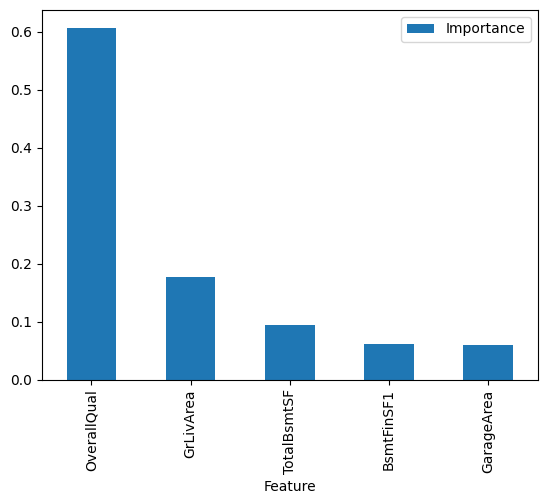

In [30]:
import matplotlib.pyplot as plt

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_regression['feat_selection'].get_support()],
    'Importance': pipeline_regression['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig('outputs/plots/feature_importance.png')
plt.show()


# Evaluate Pipeline on Train and Test Sets

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    report = {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R-squared (R²)": r2,
        "Mean Absolute Percentage Error (MAPE)": mape
    }
    return report

Train set

In [24]:
prediction = pipeline_regression.predict(X_train)

report = regression_report(y_train, prediction)
for metric, value in report.items():
    print(f"{metric}: {value}")

Mean Absolute Error (MAE): 10100.707601923232
Mean Squared Error (MSE): 219725497.52446666
Root Mean Squared Error (RMSE): 14823.140609346814
R-squared (R²): 0.9643126655320058
Mean Absolute Percentage Error (MAPE): 6.316579738155534


Test set

In [25]:
prediction = pipeline_regression.predict(X_test)

report = regression_report(y_test, prediction)
for metric, value in report.items():
    print(f'{metric}: {value}')


Mean Absolute Error (MAE): 20391.853323159772
Mean Squared Error (MSE): 1120920869.8152843
Root Mean Squared Error (RMSE): 33480.156358883454
R-squared (R²): 0.8376853138052471
Mean Absolute Percentage Error (MAPE): 11.588219177981317


### Generate regression evaluation plots



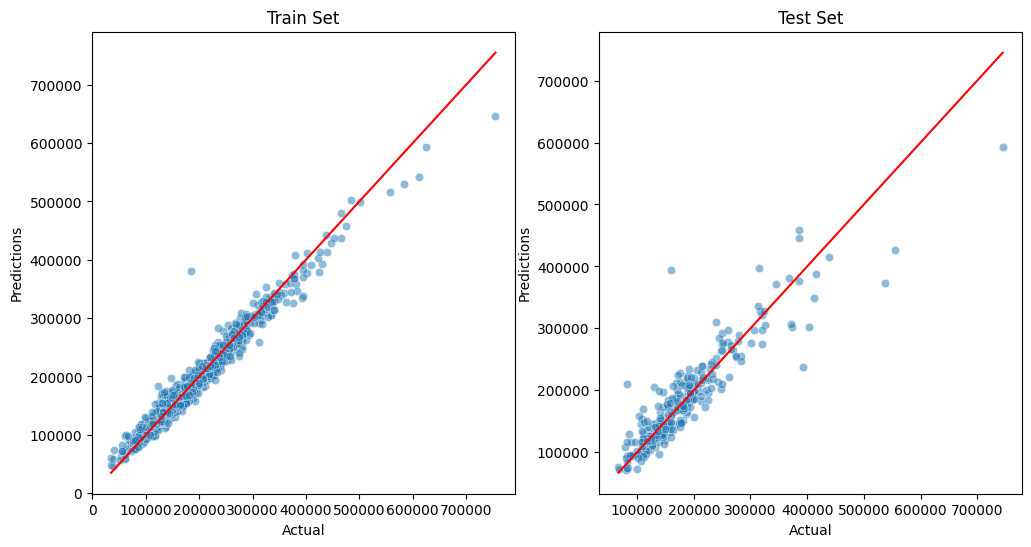

In [31]:
import seaborn as sns

def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")
  plt.savefig('outputs/plots/regression_evaluation_plots')
  plt.show()

regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression, alpha_scatter=0.5)

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.